In [39]:
!nvidia-smi

Wed Oct 11 10:44:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    30W /  70W |   1331MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4399.99
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscal
                         l nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopo
                         logy nonstop_tsc cpuid tsc_known_freq pni pclmulqdq sss
                         e3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes 
                         xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowpref

In [ ]:
"""
C++
"""

In [1]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-3b7npsdg
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-3b7npsdg
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4295 sha256=a530cb20841563d62ab95c87774297df893522e5e9b67c633fe69a626912c810
  Stored in directory: /tmp/pip-ephem-wheel-cache-1vr1jcqc/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


In [214]:
%%cuda --name vecsum.cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>
#include <iostream>
#include <iomanip>
#include <random>

#define BLOCK_DIM_X 512

int cpu_sum(int* arr, int N) {
    int sum = 0;
    for (int i = 0; i < N; ++i) {
        sum += arr[i];
    }
    return sum;
}

__global__ void gpu_sum(int* arr, int N, int* res) {

    __shared__ int temp[BLOCK_DIM_X];

    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    temp[threadIdx.x] = 0;

    if (idx < N) {
        temp[threadIdx.x] = arr[idx];
    }

    __syncthreads();

    if (threadIdx.x == 0) {
        int summ = 0;
        for (int i = 0; i < blockDim.x; ++i) {
            summ += temp[i];
        }
        atomicAdd(res, summ);
    }
}

int main(int argc, char *argv[]) {

    int N = atoi(argv[1]);

    int cpu_res;
    //удаляемое руками в одном месте
    int* h_arr = new int[N];
    int* d_arr;
    int* d_res;
    int* h_res = new int;

    //init arr
    srand(time(NULL));
    for (int i = 0; i < N; ++i)
        h_arr[i] = rand();

    clock_t start, end;

    start = clock();
    cpu_res = cpu_sum(h_arr, N);
    end = clock();

    float cpu_time = static_cast <float>(end - start) / static_cast <float>(CLOCKS_PER_SEC);
    std::cout<< std::fixed << std::setprecision(10) << "\ncpu time:\t" << cpu_time << "\tcpu res:\t" << cpu_res;

    cudaMalloc(&d_arr, N * sizeof(int));
    cudaMalloc(&d_res, sizeof(int));

    cudaMemcpy(d_arr, h_arr, N * sizeof(int), cudaMemcpyHostToDevice);
    delete[] h_arr;

    dim3 block_dim(BLOCK_DIM_X);
    dim3 grid_dim(ceil(static_cast <int> (N) / static_cast <int> (block_dim.x) + 1));

    cudaEvent_t begin, stop;
    cudaEventCreate(&begin);
    cudaEventCreate(&stop);

    cudaEventRecord(begin, 0);
    gpu_sum <<<grid_dim, block_dim>>> (d_arr, N, d_res);
    cudaEventRecord(stop, 0);

    cudaEventSynchronize(stop);
    cudaMemcpy(h_res, d_res, sizeof(int), cudaMemcpyDeviceToHost);

    float gpu_time;
    cudaEventElapsedTime(&gpu_time, begin, stop);
    std::cout<< std::fixed << std::setprecision(10) << "\ngpu time:\t" << gpu_time / 1000 << "\tgpu res:\t" << *h_res;

    cudaFree(d_arr);
    cudaFree(d_res);
    delete h_res;

    return 0;
}

'File written in /content/src/vecsum.cu'

In [217]:
!nvcc -o /content/src/vecsum /content/src/vecsum.cu

In [236]:
!/content/src/vecsum 3000000


cpu time:	0.0077650002	cpu res:	1216606754
gpu time:	0.0003962880	gpu res:	1216606754

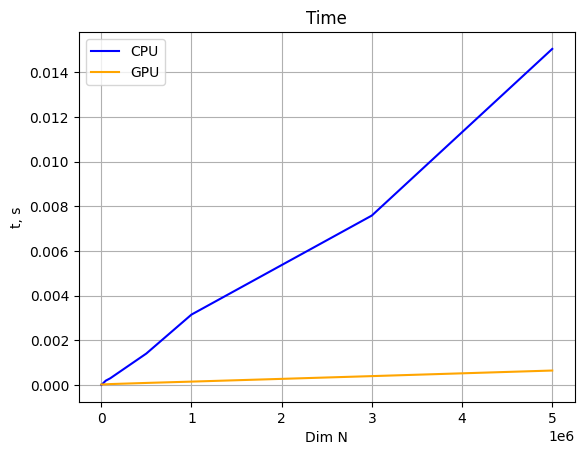

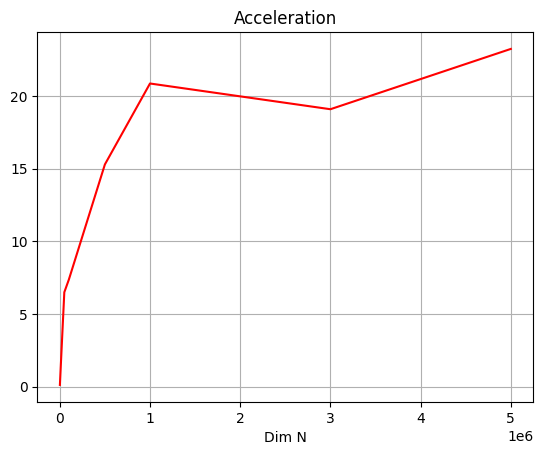

In [238]:
from matplotlib import pyplot as plt

sizes = [1000, 5000, 10000, 50000, 100000, 500000, 1000000, 3000000, 5000000]

ctimes = [0.0000030000,
          0.0000150000,
          0.0000320000,
          0.0001930000,
          0.0003000000,
          0.0014080000,
          0.0031500000,
          0.0075840000,
          0.0150420005]

gtimes = [0.0000249920,
          0.0000232000,
          0.0000244160,
          0.0000296960,
          0.0000407360,
          0.0000920320,
          0.0001509440,
          0.0003971200,
          0.0006470080]

accelerations = []
for i in range(len(sizes)):
    accelerations.append(ctimes[i] / gtimes[i])

plt.plot(sizes, ctimes, label='CPU', color='blue')
plt.plot(sizes, gtimes, label='GPU', color='orange')
plt.grid(True)
plt.legend()
plt.xlabel("Dim N")
plt.ylabel("t, s")
plt.title('Time')
plt.show()

plt.plot(sizes, accelerations, color='red')
plt.grid(True)
plt.xlabel("Dim N")
plt.title('Acceleration')
plt.show()

In [ ]:
"""
Python
"""

In [32]:
from numba import cuda, int32
import numba
import time
import numpy as np
from ctypes import *

threads_per_block = 512


@cuda.jit
def GPU_sum(vector, result):
    buffer = cuda.shared.array(threads_per_block, dtype=int32)
    idx = cuda.threadIdx.x + cuda.blockIdx.x * threads_per_block
    buffer[cuda.threadIdx.x] = 0

    if idx < vector.shape[0]:
        buffer[cuda.threadIdx.x] = vector[idx]

    cuda.syncthreads()
    if cuda.threadIdx.x == 0:
        sum = 0
        for i in range(threads_per_block):
            sum += buffer[i]
        cuda.atomic.add(result, 0, sum)


def cpu_sum_naive(arr):
    sum = 0
    for i in range(arr.shape[0]):
        sum += arr[i]
    return sum


def cpu_sum_np(arr):
    return np.sum(arr)


def compare(N: int):
    arr = np.random.randint(0, 5, N)

    start = time.time()
    cpu_res = cpu_sum_naive(arr)
    stop = time.time() - start

    print(f'\ncpu time naive:\t {stop}\tcpu res:\t {cpu_res}')

    start = time.time()
    cpu_res = cpu_sum_np(arr)
    stop = time.time() - start

    print(f'\ncpu time np:\t {stop}\tcpu res:\t {cpu_res}')

    cpu_res = np.zeros(1, dtype=np.int32)    #костыль
    g_arr = cuda.to_device(arr)
    g_res = cuda.to_device(cpu_res)

    start_g = time.time()
    GPU_sum[int( N / threads_per_block + 1), threads_per_block](g_arr, g_res)
    stop_g = time.time() - start_g

    gpu_res = g_res.copy_to_host()

    print(f'\ngpu time:\t {stop_g}\tgpu res:\t {gpu_res[0]}')


if __name__ == "__main__":
    compare(100000000)


cpu time naive:	 16.137153387069702	cpu res:	 200000892

cpu time np:	 0.06587457656860352	cpu res:	 200000892

gpu time:	 0.14592671394348145	gpu res:	 200000892


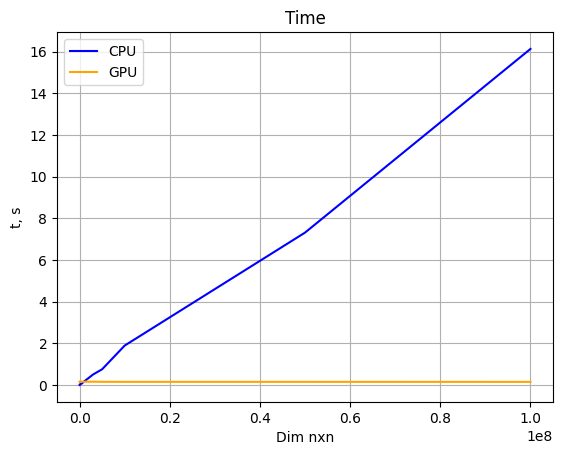

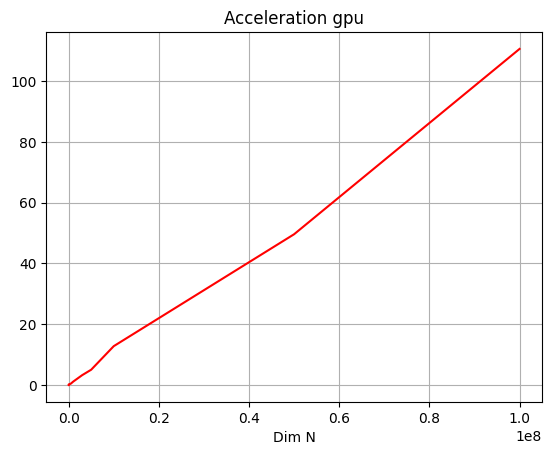

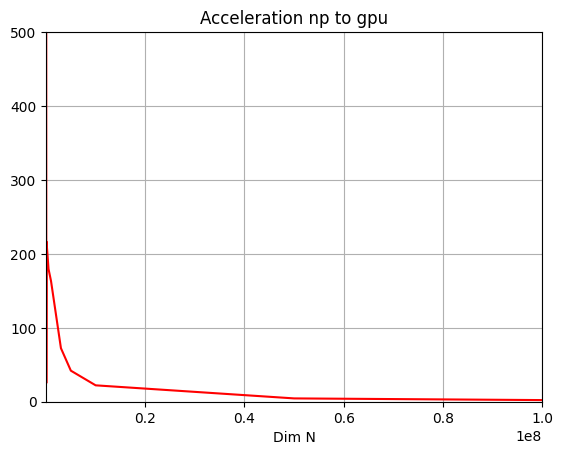

In [38]:
from matplotlib import pyplot as plt

sizes = [1000, 5000, 10000, 50000, 100000, 500000, 1000000, 3000000, 5000000, 10000000, 50000000, 100000000]
ctimes = [0.000253915786,
          0.001312017443,
          0.002664089202,
          0.028990507125,
          0.021594047546,
          0.067993879318,
          0.164069890975,
          0.501269578933,
          0.751679658882,
          1.889067649841,
          7.315609931945,
          16.13715338706
          ]
ctimes_np = [4.1961669921875e-05,
             5.0544738769531e-05,
             7.4863433837896e-05,
             0.00570249557495,
             0.00068759918211,
             0.00086474418640,
             0.00093173980712,
             0.00215220451354,
             0.00357317924499,
             0.00667905807499,
             0.03284740447989,
             0.06587457656898
             ]
gtimes = [0.1498286724006,
          0.1503036022186,
          0.1634123325347,
          0.1436986923217,
          0.1487622261047,
          0.1552379131312,
          0.1522271633148,
          0.1559338569643,
          0.1501123905188,
          0.1480929851531,
          0.1475114822387,
          0.1459267139434
          ]

accelerations = []
for i in range(len(sizes)):
    accelerations.append(ctimes[i] / gtimes[i])

accelerations_pn_to_gpu = []
for i in range(len(sizes)):
    accelerations_pn_to_gpu.append(gtimes[i] / ctimes_np[i] )

plt.plot(sizes, ctimes, label='CPU', color='blue')
plt.plot(sizes, gtimes, label='GPU', color='orange')
plt.grid(True)
plt.legend()
plt.xlabel("Dim nxn")
plt.ylabel("t, s")
plt.title('Time')
plt.show()

plt.plot(sizes, accelerations, color='red')
plt.grid(True)
plt.xlabel("Dim N")
plt.title('Acceleration gpu')
plt.show()

plt.plot(sizes, accelerations_pn_to_gpu, color='red')
plt.grid(True)
plt.xlim(1e4, 1e8)
plt.ylim(0, 500)
plt.xlabel("Dim N")
plt.title('Acceleration np to gpu')
plt.show()